In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
#**************第一步：读文本数据数据**************

f = open('stock_list11.txt','r') 
a = f.read() 
stock_list = eval(a) 
f.close()

stock_data1_df = pd.read_csv("stock_data11.csv")
stock_data1 = dict()
stock_data1_df.index= pd.to_datetime(stock_data1_df.date)
del stock_data1_df['date']
for code in stock_data1_df.keys():
    stock_data1[code] = stock_data1_df[code].dropna()

In [3]:
#**************第二步：聚类**************

#下面用聚类来进行聚类分析
def dist(stock_a,stock_b):       
    return np.sqrt(np.sum(np.power(stock_a-stock_b,2)))

#随机设置初始中心
def randcent(dataset,k):
    n=np.shape(dataset)[1]
    centers=np.mat(np.zeros((k,n)))
    for j in range(n):
        Min=min(dataset[:,j])
        Max=max(dataset[:,j])
        centers[:,j]=Min+float(Max-Min)*np.random.rand(k,1)
    return centers

#判断是否点到各中心点的距离最近的那个点的位置
def ddist(d):
    for i in range(len(d)):
        if d[i]==d.min():dd=i
    return dd

#从stock_data中构造成文龙的dataset，array
dataset = []
dataset_dict = []
for ss_code in stock_data1.keys():
    dataset.append(np.array(stock_data1[ss_code]))
    dataset_dict.append(ss_code)
dataset = np.array(dataset)
for i in range(0,len(dataset[:,0])):
    dataset[i,:]=(dataset[i,:]-dataset[i,:].min())/(dataset[i,:].max()-dataset[i,:].min())

#############################下面进行聚类#############################
m=np.shape(dataset)[0] 
k=10                          #要分多少类即有多少个中心点
centers=randcent(dataset,k)
count=0
T=True                         #判断是否需要继续迭代下去
while T:
    clusters=[]                #记录每个点所属的类别
    centers_new=[]
    one_cluster=[]
    for i in range(m):
        d=[]                   #记录当前点到中心点的距离
        for j in range(k):
            d.append(dist(dataset[i,:],centers[j,:]))   
        clusters.append(ddist(np.array(d)))   #当前点离中心点记录最近的位置，这里就相当于记录了当前点的类别
    
    clusters=np.array(clusters)
    for i in range(k):
        one_cluster=[]
        for j in range(m):
            if clusters[j]==i:
                one_cluster.append(dataset[j,:])
        one_cluster=np.array(one_cluster)
        centers_new.append(pd.DataFrame(one_cluster).apply(sum)/one_cluster.shape[0])
    centers_new=np.array(centers_new)
    
    if (centers==centers_new).all():T=False
    else:centers=centers_new
    count=count+1                         #计算迭代了多少次然后使得聚类中心不再变
        
print(centers.shape)
#print(clusters)
print("迭代次数为%d"%count)
print("")
#######################显示出分类的类别##########################

print("以下为各只股票的聚类结果") 
f = open('cluster.txt','a')
for i in range(k):
    f.write("第%d类的股票有以下："%i)
    #print("第%d类的股票有以下："%i)
    for j in range(m):
        if clusters[j]==i:
            #print("%s,%s"%(dataset_dict[j],stock_list[dataset_dict[j]]))
            f.write('\n')
            f.write("%s,%s"%(dataset_dict[j],stock_list[dataset_dict[j]]))

    f.write('\n')
f.close() 
print("")
##########################给出投资组合#############################
print("以下为推荐选股投资组合:")
Center_code = []
zuhe_code = []
for i in range(k):
    d=[]
    code_name=[]
    for j in range(m):
        if clusters[j]==i:
            d.append(dist(dataset[j,:],centers[i,:]))
            code_name.append((dataset_dict[j],stock_list[dataset_dict[j]]))
    code_name=np.array(code_name)
    cen = ddist(np.array(d))
    Center_code.append(code_name[cen,0])
    zuhe_code.append(code_name[cen,:])
zuhe_code = np.array(zuhe_code)   
f = open("pickle.txt",'wb')
pickle.dump(zuhe_code,f)
f.flush()
f.close()
  
#print(code_name[cen,:])

(10, 100)
迭代次数为33

以下为各只股票的聚类结果

以下为推荐选股投资组合:


In [4]:
#将投资组合的数据保存为csv文件
import pandas as pd
hha=pickle.load(file=open('pickle.txt','rb'))
data=pd.DataFrame(hha)
data.to_csv('zuhe.csv',encoding='utf_8_sig')

In [5]:
#************************LSTM时序预测**************************
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
day_predict = 10                                                  #预测的天数
stock_predict = dict()                                            #存储预测结果
look_back = 15
model = Sequential()
model.add(LSTM(20,input_shape=(1,look_back),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(40,input_shape =(1,20),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(80,input_shape =(1,40)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')


predict_data=[]
true_data=[]

for code in Center_code:
    ss = stock_data1[code].sort_index().dropna().values            #ss mean stock_series
    x_train,y_train = create_dataset(ss,look_back)
    x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
    model.fit(x=x_train,y=y_train,nb_epoch=150,batch_size=10)
    predict = model.predict(x_train)
    predict_data.append(predict)
    true_data.append(ss[look_back+1:])
    stock_predict[code]=predict
    predict=[]

Using TensorFlow backend.
e:\python3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/150
84/84 [==============================] - 1s 17ms/step - loss: 4.9000
Epoch 2/150
84/84 [==============================] - 0s 834us/step - loss: 4.8744
Epoch 3/150
84/84 [==============================] - 0s 858us/step - loss: 4.8534
Epoch 4/150
84/84 [==============================] - 0s 834us/step - loss: 4.8227
Epoch 5/150
84/84 [==============================] - 0s 870us/step - loss: 4.7835
Epoch 6/150
84/84 [==============================] - 0s 929us/step - loss: 4.7391
Epoch 7/150
84/84 [==============================] - 0s 858us/step - loss: 4.6328
Epoch 8/150
84/84 [==============================] - 0s 905us/step - loss: 4.5477
Epoch 9/150
84/84 [==============================] - 0s 798us/step - loss: 4.4244
Epoch 10/150
84/84 [==============================] - 0s 941us/step - loss: 4.2684
Epoch 11/150
84/84 [==============================] - 0s 905us/step - loss: 4.0387
Epoch 12/150
84/84 [==============================] - 0s 929us/step - loss: 3.6761
Epoch 13/150
8

84/84 [==============================] - 0s 715us/step - loss: 0.4212
Epoch 100/150
84/84 [==============================] - 0s 667us/step - loss: 0.6222
Epoch 101/150
84/84 [==============================] - 0s 917us/step - loss: 0.5225
Epoch 102/150
84/84 [==============================] - 0s 810us/step - loss: 0.4873
Epoch 103/150
84/84 [==============================] - 0s 632us/step - loss: 0.3497
Epoch 104/150
84/84 [==============================] - 0s 661us/step - loss: 0.6540
Epoch 105/150
84/84 [==============================] - 0s 794us/step - loss: 0.6759
Epoch 106/150
84/84 [==============================] - 0s 885us/step - loss: 0.3649
Epoch 107/150
84/84 [==============================] - 0s 657us/step - loss: 0.5630
Epoch 108/150
84/84 [==============================] - 0s 684us/step - loss: 0.6485
Epoch 109/150
84/84 [==============================] - 0s 888us/step - loss: 0.5006
Epoch 110/150
84/84 [==============================] - 0s 893us/step - loss: 0.5591
Epoch 

84/84 [==============================] - 0s 751us/step - loss: 0.5676
Epoch 48/150
84/84 [==============================] - 0s 762us/step - loss: 0.7319
Epoch 49/150
84/84 [==============================] - 0s 750us/step - loss: 0.5742
Epoch 50/150
84/84 [==============================] - 0s 727us/step - loss: 0.6911
Epoch 51/150
84/84 [==============================] - 0s 810us/step - loss: 0.7464
Epoch 52/150
84/84 [==============================] - 0s 834us/step - loss: 1.1060
Epoch 53/150
84/84 [==============================] - 0s 610us/step - loss: 0.8073
Epoch 54/150
84/84 [==============================] - 0s 774us/step - loss: 0.9421
Epoch 55/150
84/84 [==============================] - 0s 679us/step - loss: 0.4751
Epoch 56/150
84/84 [==============================] - 0s 808us/step - loss: 0.6866
Epoch 57/150
84/84 [==============================] - 0s 709us/step - loss: 0.7306
Epoch 58/150
84/84 [==============================] - 0s 840us/step - loss: 0.7372
Epoch 59/150
84/8

84/84 [==============================] - 0s 655us/step - loss: 0.3574
Epoch 146/150
84/84 [==============================] - 0s 727us/step - loss: 0.2899
Epoch 147/150
84/84 [==============================] - 0s 751us/step - loss: 0.5017
Epoch 148/150
84/84 [==============================] - 0s 683us/step - loss: 0.4497
Epoch 149/150
84/84 [==============================] - 0s 985us/step - loss: 0.3245
Epoch 150/150
84/84 [==============================] - 0s 834us/step - loss: 0.4126
Epoch 1/150
84/84 [==============================] - 0s 671us/step - loss: 9.5884
Epoch 2/150
84/84 [==============================] - 0s 807us/step - loss: 8.3888
Epoch 3/150
84/84 [==============================] - 0s 676us/step - loss: 7.5880
Epoch 4/150
84/84 [==============================] - 0s 678us/step - loss: 6.7816
Epoch 5/150
84/84 [==============================] - 0s 823us/step - loss: 6.6202
Epoch 6/150
84/84 [==============================] - 0s 822us/step - loss: 5.9226
Epoch 7/150
84/84 

84/84 [==============================] - 0s 715us/step - loss: 0.6242
Epoch 94/150
84/84 [==============================] - 0s 679us/step - loss: 0.4484
Epoch 95/150
84/84 [==============================] - 0s 667us/step - loss: 0.9833
Epoch 96/150
84/84 [==============================] - 0s 697us/step - loss: 0.6278
Epoch 97/150
84/84 [==============================] - 0s 825us/step - loss: 0.4735
Epoch 98/150
84/84 [==============================] - 0s 662us/step - loss: 0.4819
Epoch 99/150
84/84 [==============================] - 0s 950us/step - loss: 1.1811
Epoch 100/150
84/84 [==============================] - 0s 929us/step - loss: 0.6383
Epoch 101/150
84/84 [==============================] - 0s 817us/step - loss: 0.6075
Epoch 102/150
84/84 [==============================] - 0s 772us/step - loss: 0.8644
Epoch 103/150
84/84 [==============================] - 0s 860us/step - loss: 0.7957
Epoch 104/150
84/84 [==============================] - 0s 672us/step - loss: 0.7337
Epoch 105/15

84/84 [==============================] - 0s 673us/step - loss: 1.5594
Epoch 42/150
84/84 [==============================] - 0s 858us/step - loss: 0.8114
Epoch 43/150
84/84 [==============================] - 0s 864us/step - loss: 1.1770
Epoch 44/150
84/84 [==============================] - 0s 858us/step - loss: 1.6041
Epoch 45/150
84/84 [==============================] - 0s 847us/step - loss: 1.0983
Epoch 46/150
84/84 [==============================] - 0s 843us/step - loss: 0.9554
Epoch 47/150
84/84 [==============================] - 0s 1ms/step - loss: 1.1753
Epoch 48/150
84/84 [==============================] - 0s 1ms/step - loss: 1.4136
Epoch 49/150
84/84 [==============================] - 0s 979us/step - loss: 0.9474
Epoch 50/150
84/84 [==============================] - 0s 929us/step - loss: 1.0922
Epoch 51/150
84/84 [==============================] - 0s 858us/step - loss: 1.5248
Epoch 52/150
84/84 [==============================] - 0s 917us/step - loss: 1.0931
Epoch 53/150
84/84 [=

84/84 [==============================] - 0s 834us/step - loss: 0.7849
Epoch 140/150
84/84 [==============================] - 0s 703us/step - loss: 0.7375
Epoch 141/150
84/84 [==============================] - 0s 679us/step - loss: 0.6102
Epoch 142/150
84/84 [==============================] - 0s 739us/step - loss: 0.7601
Epoch 143/150
84/84 [==============================] - 0s 745us/step - loss: 0.7714
Epoch 144/150
84/84 [==============================] - 0s 772us/step - loss: 0.5628
Epoch 145/150
84/84 [==============================] - 0s 701us/step - loss: 0.4538
Epoch 146/150
84/84 [==============================] - 0s 1ms/step - loss: 0.4795
Epoch 147/150
84/84 [==============================] - 0s 858us/step - loss: 0.3979
Epoch 148/150
84/84 [==============================] - 0s 746us/step - loss: 0.8551
Epoch 149/150
84/84 [==============================] - 0s 858us/step - loss: 0.4230
Epoch 150/150
84/84 [==============================] - 0s 846us/step - loss: 1.1709
Epoch 1/

84/84 [==============================] - 0s 715us/step - loss: 0.7355
Epoch 88/150
84/84 [==============================] - 0s 679us/step - loss: 0.7076
Epoch 89/150
84/84 [==============================] - 0s 655us/step - loss: 0.5094
Epoch 90/150
84/84 [==============================] - 0s 798us/step - loss: 0.7679
Epoch 91/150
84/84 [==============================] - 0s 906us/step - loss: 0.6079
Epoch 92/150
84/84 [==============================] - 0s 858us/step - loss: 0.7056
Epoch 93/150
84/84 [==============================] - 0s 835us/step - loss: 0.6597
Epoch 94/150
84/84 [==============================] - 0s 759us/step - loss: 0.6035
Epoch 95/150
84/84 [==============================] - 0s 844us/step - loss: 0.4240
Epoch 96/150
84/84 [==============================] - 0s 882us/step - loss: 0.4825
Epoch 97/150
84/84 [==============================] - 0s 810us/step - loss: 0.8392
Epoch 98/150
84/84 [==============================] - 0s 810us/step - loss: 0.5025
Epoch 99/150
84/8

84/84 [==============================] - 0s 732us/step - loss: 0.7823
Epoch 36/150
84/84 [==============================] - 0s 643us/step - loss: 1.0226
Epoch 37/150
84/84 [==============================] - 0s 727us/step - loss: 0.9330
Epoch 38/150
84/84 [==============================] - 0s 687us/step - loss: 0.9930
Epoch 39/150
84/84 [==============================] - 0s 965us/step - loss: 0.8201
Epoch 40/150
84/84 [==============================] - 0s 834us/step - loss: 0.6492
Epoch 41/150
84/84 [==============================] - 0s 764us/step - loss: 1.1382
Epoch 42/150
84/84 [==============================] - 0s 791us/step - loss: 0.8972
Epoch 43/150
84/84 [==============================] - 0s 903us/step - loss: 0.5733
Epoch 44/150
84/84 [==============================] - 0s 830us/step - loss: 0.7744
Epoch 45/150
84/84 [==============================] - 0s 798us/step - loss: 0.9579
Epoch 46/150
84/84 [==============================] - 0s 846us/step - loss: 0.8379
Epoch 47/150
84/8

84/84 [==============================] - 0s 786us/step - loss: 0.5107
Epoch 134/150
84/84 [==============================] - 0s 703us/step - loss: 0.4572
Epoch 135/150
84/84 [==============================] - 0s 667us/step - loss: 0.4454
Epoch 136/150
84/84 [==============================] - 0s 830us/step - loss: 0.6301
Epoch 137/150
84/84 [==============================] - 0s 928us/step - loss: 0.5520
Epoch 138/150
84/84 [==============================] - 0s 762us/step - loss: 0.6720
Epoch 139/150
84/84 [==============================] - 0s 649us/step - loss: 0.7170
Epoch 140/150
84/84 [==============================] - 0s 683us/step - loss: 0.5934
Epoch 141/150
84/84 [==============================] - 0s 666us/step - loss: 0.4512
Epoch 142/150
84/84 [==============================] - 0s 832us/step - loss: 0.5176
Epoch 143/150
84/84 [==============================] - 0s 965us/step - loss: 0.6722
Epoch 144/150
84/84 [==============================] - 0s 917us/step - loss: 0.4017
Epoch 

84/84 [==============================] - 0s 834us/step - loss: 0.4984
Epoch 82/150
84/84 [==============================] - 0s 822us/step - loss: 0.4608
Epoch 83/150
84/84 [==============================] - 0s 810us/step - loss: 0.3855
Epoch 84/150
84/84 [==============================] - 0s 754us/step - loss: 0.4821
Epoch 85/150
84/84 [==============================] - 0s 784us/step - loss: 0.4219
Epoch 86/150
84/84 [==============================] - 0s 986us/step - loss: 0.3799
Epoch 87/150
84/84 [==============================] - 0s 767us/step - loss: 0.4520
Epoch 88/150
84/84 [==============================] - 0s 681us/step - loss: 0.5431
Epoch 89/150
84/84 [==============================] - 0s 803us/step - loss: 0.3981
Epoch 90/150
84/84 [==============================] - 0s 859us/step - loss: 0.3554
Epoch 91/150
84/84 [==============================] - 0s 858us/step - loss: 0.3919
Epoch 92/150
84/84 [==============================] - 0s 846us/step - loss: 0.4136
Epoch 93/150
84/8

84/84 [==============================] - 0s 756us/step - loss: 1.4534
Epoch 30/150
84/84 [==============================] - 0s 810us/step - loss: 1.1507
Epoch 31/150
84/84 [==============================] - 0s 830us/step - loss: 1.0046
Epoch 32/150
84/84 [==============================] - 0s 852us/step - loss: 0.8625
Epoch 33/150
84/84 [==============================] - 0s 870us/step - loss: 1.0267
Epoch 34/150
84/84 [==============================] - 0s 786us/step - loss: 0.9798
Epoch 35/150
84/84 [==============================] - 0s 661us/step - loss: 1.0797
Epoch 36/150
84/84 [==============================] - 0s 822us/step - loss: 0.8202
Epoch 37/150
84/84 [==============================] - 0s 834us/step - loss: 0.7845
Epoch 38/150
84/84 [==============================] - 0s 822us/step - loss: 1.0820
Epoch 39/150
84/84 [==============================] - 0s 844us/step - loss: 1.0515
Epoch 40/150
84/84 [==============================] - 0s 727us/step - loss: 0.9805
Epoch 41/150
84/8

84/84 [==============================] - 0s 727us/step - loss: 0.5569
Epoch 128/150
84/84 [==============================] - 0s 667us/step - loss: 0.5553
Epoch 129/150
84/84 [==============================] - 0s 750us/step - loss: 0.5800
Epoch 130/150
84/84 [==============================] - 0s 703us/step - loss: 0.4385
Epoch 131/150
84/84 [==============================] - 0s 755us/step - loss: 0.4974
Epoch 132/150
84/84 [==============================] - 0s 1ms/step - loss: 0.6192
Epoch 133/150
84/84 [==============================] - 0s 810us/step - loss: 0.4564
Epoch 134/150
84/84 [==============================] - 0s 819us/step - loss: 0.6617
Epoch 135/150
84/84 [==============================] - 0s 727us/step - loss: 0.2945
Epoch 136/150
84/84 [==============================] - 0s 668us/step - loss: 0.6463
Epoch 137/150
84/84 [==============================] - 0s 930us/step - loss: 0.4791
Epoch 138/150
84/84 [==============================] - 0s 929us/step - loss: 0.3643
Epoch 13

84/84 [==============================] - 0s 810us/step - loss: 0.7435
Epoch 76/150
84/84 [==============================] - 0s 703us/step - loss: 1.2219
Epoch 77/150
84/84 [==============================] - 0s 762us/step - loss: 0.9976
Epoch 78/150
84/84 [==============================] - 0s 917us/step - loss: 0.7981
Epoch 79/150
84/84 [==============================] - 0s 841us/step - loss: 0.9675
Epoch 80/150
84/84 [==============================] - 0s 957us/step - loss: 1.0443
Epoch 81/150
84/84 [==============================] - 0s 953us/step - loss: 1.0002
Epoch 82/150
84/84 [==============================] - 0s 752us/step - loss: 0.8632
Epoch 83/150
84/84 [==============================] - 0s 929us/step - loss: 0.5794
Epoch 84/150
84/84 [==============================] - 0s 893us/step - loss: 0.8791
Epoch 85/150
84/84 [==============================] - 0s 713us/step - loss: 0.8293
Epoch 86/150
84/84 [==============================] - 0s 925us/step - loss: 1.0909
Epoch 87/150
84/8

84/84 [==============================] - 0s 858us/step - loss: 5.5043
Epoch 24/150
84/84 [==============================] - 0s 739us/step - loss: 5.0457
Epoch 25/150
84/84 [==============================] - 0s 810us/step - loss: 4.8582
Epoch 26/150
84/84 [==============================] - 0s 754us/step - loss: 4.4372
Epoch 27/150
84/84 [==============================] - 0s 823us/step - loss: 3.9808
Epoch 28/150
84/84 [==============================] - 0s 870us/step - loss: 3.9881
Epoch 29/150
84/84 [==============================] - 0s 786us/step - loss: 5.1013
Epoch 30/150
84/84 [==============================] - 0s 790us/step - loss: 3.2291
Epoch 31/150
84/84 [==============================] - 0s 755us/step - loss: 4.3003
Epoch 32/150
84/84 [==============================] - 0s 839us/step - loss: 3.2751
Epoch 33/150
84/84 [==============================] - 0s 902us/step - loss: 2.8335
Epoch 34/150
84/84 [==============================] - 0s 798us/step - loss: 2.6662
Epoch 35/150
84/8

84/84 [==============================] - 0s 667us/step - loss: 1.5682
Epoch 122/150
84/84 [==============================] - 0s 762us/step - loss: 1.8139
Epoch 123/150
84/84 [==============================] - 0s 727us/step - loss: 1.9060
Epoch 124/150
84/84 [==============================] - 0s 845us/step - loss: 2.0751
Epoch 125/150
84/84 [==============================] - 0s 744us/step - loss: 2.3086
Epoch 126/150
84/84 [==============================] - 0s 908us/step - loss: 2.3286
Epoch 127/150
84/84 [==============================] - 0s 820us/step - loss: 1.4555
Epoch 128/150
84/84 [==============================] - 0s 810us/step - loss: 1.1099
Epoch 129/150
84/84 [==============================] - 0s 774us/step - loss: 1.8428
Epoch 130/150
84/84 [==============================] - 0s 887us/step - loss: 1.7946
Epoch 131/150
84/84 [==============================] - 0s 941us/step - loss: 2.1292
Epoch 132/150
84/84 [==============================] - 0s 750us/step - loss: 1.4958
Epoch 

In [6]:
predict_data=np.array(predict_data)
print(predict_data.shape)
predict_data1=predict_data[:,:,0]
#predict_data1=np.transpose(predict_data1)
true_data=np.array(true_data)
print(predict_data1.shape)
print(true_data.shape)

pre=pd.DataFrame(predict_data1)
pre.to_csv('pre.csv')

true=pd.DataFrame(true_data)
true.to_csv('true.csv')


(10, 84, 1)
(10, 84)
(10, 84)


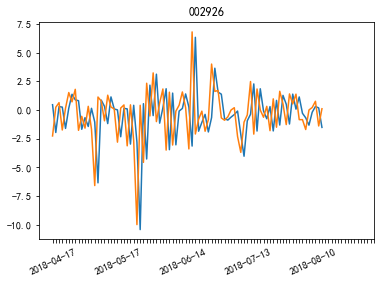

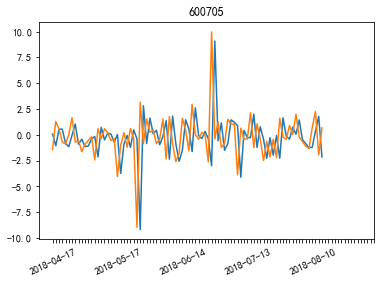

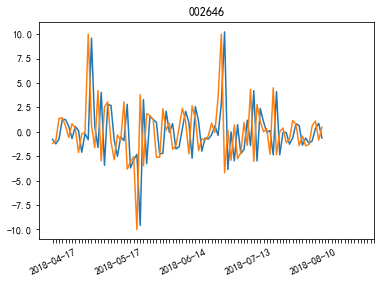

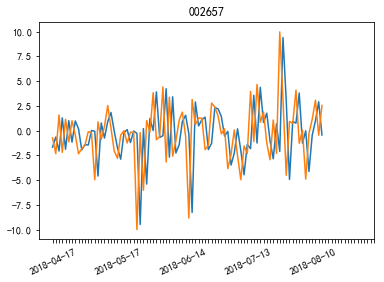

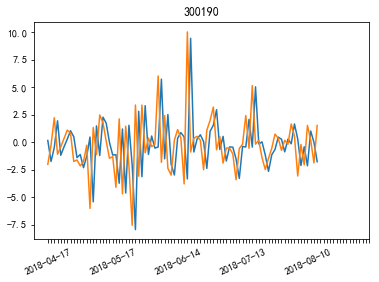

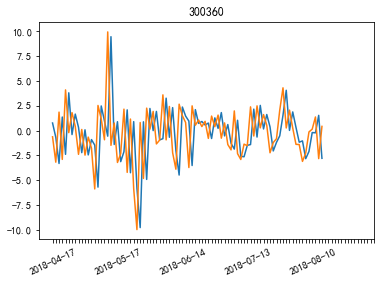

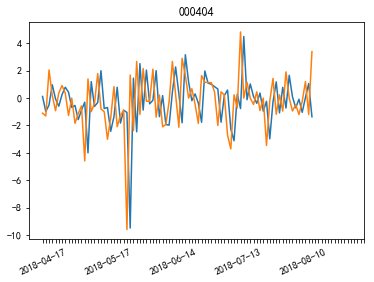

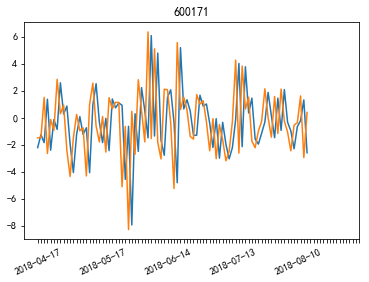

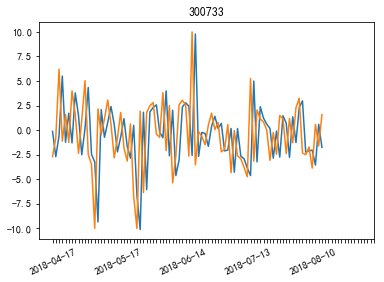

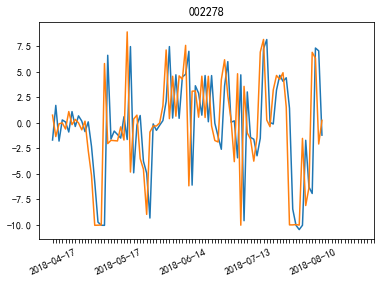

In [7]:

for key in stock_predict.keys():
    plt.figure(key)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    predict=stock_predict[key]

    pydate_array = stock_data1[key].keys().to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    my_x = pd.Series(date_only_array)


    new_x=[]
    for i in range(my_x.shape[0]):
        if i%20 != 0 :
            new_x.append('')
        else:new_x.append(my_x[i])
        

    ss = stock_data1[key].sort_index().dropna().values  
    plt.plot(predict)
    plt.plot(ss[look_back+1:])
    sss=range(100)
    plt.xticks(sss,new_x,rotation=25)
    plt.title(key)
    #plt.savefig(key,'.png')
    
    
    
    
    

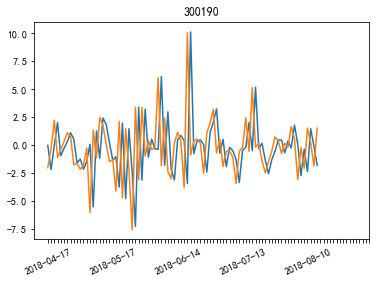

In [16]:
    key='300190'
    plt.figure(key)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    predict=stock_predict[key]

    pydate_array = stock_data1[key].keys().to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    my_x = pd.Series(date_only_array)


    new_x=[]
    for i in range(my_x.shape[0]):
        if i%20 != 0 :
            new_x.append('')
        else:new_x.append(my_x[i])
        

    ss = stock_data1[key].sort_index().dropna().values  
    plt.plot(predict)
    plt.plot(ss[look_back+1:])
    sss=range(100)
    plt.xticks(sss,new_x,rotation=25)
    plt.title(key)
    plt.savefig('300190.png')